# End-to-End Pipeline: YOLO → ResNet (Translation + Rotation) → 6D Pose (Minimal Version)
This minimal version runs the end-to-end pipeline for 6D pose estimation on LineMOD, inspired by the notebook test6_extension_endtoend_pipeline.ipynb.

**Note:** This minimal pipeline runs only one test batch and shows the predicted translation and rotation. For full evaluation and metrics, see the original notebook test6_extension_endtoend_pipeline.ipynb.

## 1. Essential imports and minimal setup

In [1]:
# Essential imports and minimal setup
import os
import sys
import pandas as pd
from pathlib import Path
import torch

sys.path.insert(0, str(Path.cwd().parent))
from config import Config
from models.pose_estimator_endtoend import PoseEstimator
from models.yolo_detector import YOLODetector
from dataset.linemod_pose import create_pose_dataloaders
from utils.file_io import load_validation_results
from utils.visualization import plot_add_per_class, calc_add_accuracy_per_class
from utils.validation import run_yolo_endtoend_pipeline
from utils.model_loader import load_model_checkpoint, ensure_model_available


## 2. Load pre-trained models (YOLO and PoseEstimator End-to-End)

In [ ]:
DATASET_DIR = Path(Config.LINEMOD_ROOT)
if not DATASET_DIR.exists():
    print("Dataset not found, start downloading...")
    from utils.download_dataset import download_linemod_dataset
    download_linemod_dataset()
else:
    print("Dataset LineMOD present.")

In [2]:
train_loader, val_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.LINEMOD_ROOT,
    batch_size=Config.POSE_BATCH_SIZE,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS_POSE
)

In [3]:
# Load pre-trained models (YOLO and PoseEstimator End-to-End)

# Load YOLO detector
yolo_checkpoint_path = ensure_model_available("yolo_train20", check_exists_only=True)
yolo_detector = YOLODetector(model_name=str(yolo_checkpoint_path), num_classes=Config.NUM_CLASSES)

# Load PoseEstimator End-to-End
NAME = "pose_rgb_endtoend"
model_endtoend = PoseEstimator(pretrained=True)
model_endtoend = load_model_checkpoint(NAME, model_endtoend, device=str(Config.DEVICE))
model_endtoend.eval()


Checkpoint found: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/yolo/yolo_train20/weights/best.pt
Loading custom weights: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/yolo/yolo_train20/weights/best.pt


/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ PoseEstimator initialized
   Backbone: resnet50 (pretrained=True, frozen=False)
   Feature dim: 2048
   Output: 7 values (4 quaternion + 3 translation)
   Dropout: 0.5
Downloaded to /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt
Checkpoint found: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/weights/best.pt
Weights loaded successfully for pose_rgb_endtoend


PoseEstimator(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

## 3. Full pipeline YOLO + ResNet End-to-End

Evaluate the complete end-to-end pipeline with YOLO detection on full-size images.  
You can choose between:
- **Quick debug**: 10 images (cell 4.1)
- **Full validation**: the entire test set (cell 4.2)

In [ ]:
# 🐛 QUICK DEBUG: Test YOLO end-to-end pipeline on only 10 images
# Use max_samples=10 for quick debug
run_yolo_endtoend_pipeline(
    yolo_detector, 
    model_endtoend, 
    test_loader, 
    name=NAME,
    max_samples=10  # 🔧 Only 10 images for quick debug
)

print("\n💡 For full validation on the entire test set, run the next cell!")

Using model pose_rgb_endtoend
Carico modelli 3D degli oggetti in memoria.
Questi vengono usati per calcolare la metrica ADD.
Loaded model 01: 5841 points
Loaded model 02: 38325 points
Loaded model 04: 18995 points
Loaded model 05: 22831 points
Loaded model 06: 15736 points
Loaded model 08: 12655 points
Loaded model 09: 7912 points
Loaded model 10: 18473 points
Loaded model 11: 7479 points
Loaded model 12: 15972 points
Loaded model 13: 18216 points
Loaded model 14: 27435 points
Loaded model 15: 16559 points


Validating YOLO pipeline (end-to-end, max 10 samples):   0%|          | 0/210 [00:02<?, ?it/s]

Samples processed: 64
Detection failures: 0
Computing full pose ADD metrics
Risultati di validazione salvati in /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/validation_result.csv
Results saved to /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/validation_result.csv

💡 For full validation on the entire test set, run the next cell!


In [ ]:
# 🚀 FULL VALIDATION: Run the end-to-end pipeline on the ENTIRE test set
# ⚠️ This cell may take several minutes. For quick debug use the previous cell (10 images)

# Process the entire test set (no limit)
run_yolo_endtoend_pipeline(yolo_detector, model_endtoend, test_loader, name=NAME)

Using model pose_rgb_endtoend
Carico modelli 3D degli oggetti in memoria.
Questi vengono usati per calcolare la metrica ADD.
Loaded model 01: 5841 points
Loaded model 02: 38325 points
Loaded model 04: 18995 points
Loaded model 05: 22831 points
Loaded model 06: 15736 points
Loaded model 08: 12655 points
Loaded model 09: 7912 points
Loaded model 10: 18473 points
Loaded model 11: 7479 points
Loaded model 12: 15972 points
Loaded model 13: 18216 points
Loaded model 14: 27435 points
Loaded model 15: 16559 points


Validating YOLO pipeline (end-to-end): 100%|██████████| 210/210 [06:09<00:00,  1.76s/it]

Samples processed: 13405
Detection failures: 2
Computing full pose ADD metrics


Risultati di validazione salvati in /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/validation_result.csv
Results saved to /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_rgb_endtoend/validation_result.csv


## 4. Load and show per-class metrics table (ADD full pose)

In [ ]:
# Load and show per-class metrics table (ADD full pose)
val_csv_path = os.path.join(Config.CHECKPOINT_DIR, 'pose', NAME, 'validation_result.csv')
results_full_pose, _ = load_validation_results(val_csv_path)

data, global_add, global_acc = calc_add_accuracy_per_class(results_full_pose, Config.LINEMOD_OBJECTS)

df = pd.DataFrame(data)
display(df)
print(f"\nGlobal mean ADD (full pose): {global_add:.2f}")
print(f"Global accuracy (full pose) (%): {global_acc:.1f}")

,Class,ADD (mm),Accuracy (%)
0,01 - ape,49.94,0.1
1,02 - benchvise,90.92,0.5
2,04 - camera,84.98,0.1
3,05 - can,84.08,0.7
4,06 - cat,55.94,1.8
5,08 - driller,102.49,0.3
6,09 - duck,53.31,0.1
7,10 - eggbox,11.48,100.0
8,11 - glue,20.51,27.4
9,12 - holepuncher,61.32,0.9



Global mean ADD (full pose): 70.85
Global accuracy (full pose) (%): 10.5


## 5. Bar chart of mean ADD per class
Shows the means of the ADD metric for each object class, calculated on the predicted rotation-translation.

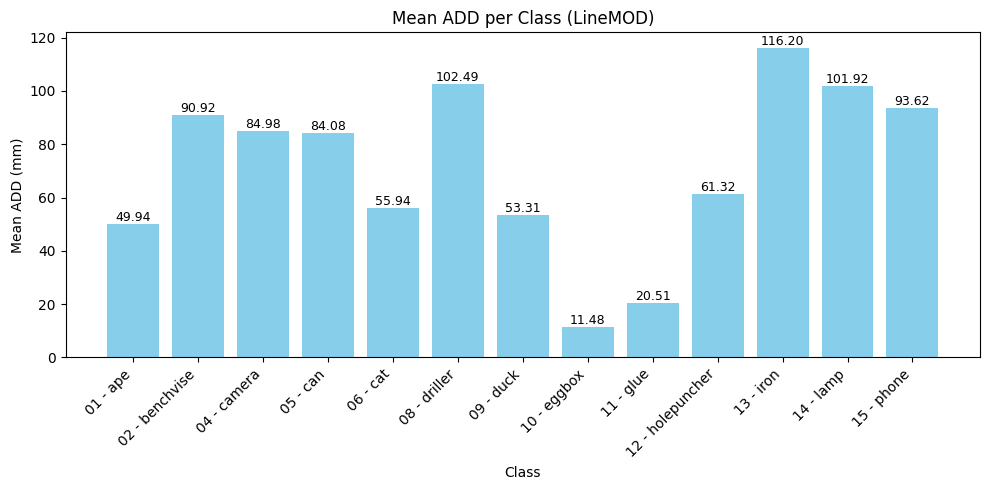

In [ ]:
# Bar chart of mean ADD per class (full pose end-to-end)
results_full_pose = globals().get('results_full_pose', None)
if results_full_pose is None:
    print("⚠️  You must first compute the ADD full pose metric on the entire test set and save the results in 'results_full_pose'.")
else:
    plot_add_per_class(results_full_pose, Config.LINEMOD_OBJECTS)